#  Linear classification, multi class based on a 2D (2 features) problem

Following the binary (2 class) classification, let's generalize to more classes.

In this workbook, no additional gaussian (wite) noise is added to the generated data. It means that in theory 100% accuracy is possible.

In [1]:
from tensorflow import keras
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from sklearn import metrics as skMetrics
import scikitplot as skplt
import scipy as sy
import pandas

In [2]:
usingTensorBoard = False

## Czech flag split of the 2D plan

Let's use the Czech flag as a  pattern to fit with a 3 class linear regression.
Czech flag is made of three areas which are separated by segments. It should be separable with linear boundaries.

### Data model for the Czech flag

In [3]:
# Czech flag colors
czechColors = ['blue', 'red', 'white']
nFeatures = 2
nClasses = 3
# Generate a multi class sample based on the Czech banner geometry. Tip of the triangle if at the origin
def generateCzechBatch(n):
    # xMax adjusted such that the 3 classes are quasi equiprobable
    xMin = np.array([-1, -1])
    xMax = np.array([0.5, 1])
    #
    x = random.uniform(xMin, xMax, (n, nFeatures))
    y = np.zeros(n)
    y[x[:,1] > 0]  = 2                                       # White
    y[x[:,1] <= 0] = 1                                       # Red
    y[(x[:,0] <= 0) & (np.abs(x[:,1]) < np.abs(x[:,0]))] = 0 # Blue triangle
    return x, y

In [4]:
# Helper to plot the flag as a 2D parametric label
def flagPlot(x0, x1, y, title, colors):
    ax = plt.gca()
    ax.set_facecolor((0.8, 0.8, 0.8))
    plt.scatter(x0, x1, c=y, cmap=pltcolors.ListedColormap(colors), marker='x', alpha=0.2);
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.grid()
    plt.title(title)
    cb = plt.colorbar()
    loc = np.arange(0,2.1,1)
    cb.set_ticks(loc)
    cb.set_ticklabels([0,1,2]);

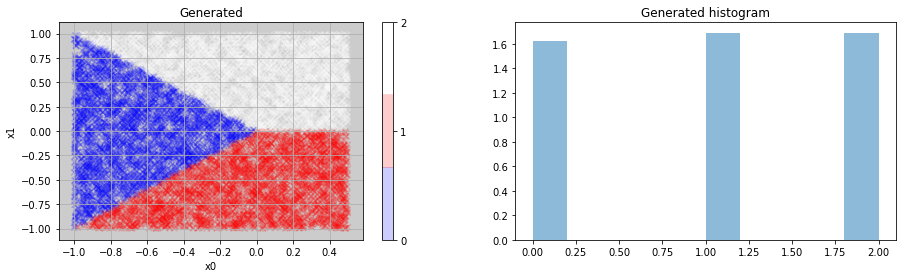

In [5]:
N = 10000
xTrain, yTrain = generateCzechBatch(N)
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
flagPlot(xTrain[:,0], xTrain[:,1], yTrain, 'Generated', czechColors)
plt.subplot(1,2,2)
plt.hist(yTrain, 10, density=True, alpha=0.5)
plt.title('Generated histogram');

### Test data

In [6]:
xTest, yTest = generateCzechBatch(N)

## Softmax regression

Maximum a posteriori with softmax is the generalization of the logistic regression in case number of classes is greater than 2.

The softmax will normalize the set of output values to a sum of 1, outputs are then probabilities.

With K the number of classes:
\begin{align}
y \in \left\{ 1 ... K \right\}
\end{align}

The softmax probability law of Y is:
\begin{align}
p (Y=c \mid x, w) & = \frac{e^{w_{c} x }}{\sum_{j=1}^{K}e^{w_{j} x}} 
\end{align}

We are looking for the value of w that maximizes the likelyhood:
\begin{align}
\hat{w} & = \max_{w}{\prod_{i=0}^N{p(y_i \mid  x_i, w)}} \\
& = \max_{w}{\sum_{i=0}^N{log \bigl(p(y_i \mid x_i, w)\bigr)} } \\
& = \max_{w}{\sum_{c=1}^K\sum_{i=0}^N{log \biggl(1_{y_i=c} * \bigl(\frac{e^{w_{c} x }}{\sum_{j=1}^{K}e^{w_{j} x}}\bigr) \biggr)} } \\
\end{align}

Where $1_{y_i=c}$ is the indicator function which takes value 1 if $y_i=c$ and 0 otherwise

When using an iterative gradient descent, the __cost function__ is then defined as:
\begin{align}
J_w = - \sum_{c=1}^K\sum_{i=0}^N{log \biggl(1_{y_i=c} * \bigl(\frac{e^{w_{c} x }}{\sum_{j=1}^{K}e^{w_{j} x}}\bigr) \biggr)}
\end{align}

Reference:
- https://en.wikipedia.org/wiki/Multinomial_logistic_regression
- http://deeplearning.stanford.edu/tutorial/supervised/SoftmaxRegression/


## Using Keras with TensorFlow backend

### Gradient descent with softmax output using Keras

Keras is used as a single layer of perceptron with softmax activation.

References:
- https://www.kaggle.com/pierrek20/multiclass-iris-prediction-with-tensorflow-keras

The simplest model of linear regression is based on a single layers with as many neurons as the number of classes (=3). The activation of the layer is a softmax with takes reference values (y/label train) in range \[0,3)

In [7]:
# Number of epochs
nEpoch = 256
nBatch = 128 # 32 is default

# Model
model0 = keras.models.Sequential([
  keras.layers.Dense(nClasses, activation=keras.activations.softmax, input_shape=[nFeatures])
])
model0.compile(optimizer='adam',
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# Tensor board display
callbacks = []
if usingTensorBoard:
    ks = keras.callbacks.TensorBoard(log_dir="./logs/", histogram_freq=1, write_graph=True, write_grads=True, batch_size=1)
    callbacks = [ks]

# Fit
hist0 = model0.fit(xTrain, yTrain, epochs=nEpoch, batch_size=nBatch, verbose=0, callbacks=callbacks)

W0805 14:32:04.171869 20876 deprecation.py:506] From c:\users\antoi\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
weights0, biases0 = model0.get_weights()
print('Est W=', weights0)
print('b=', biases0)

Est W= [[ -6.4785743   6.0854454   5.7995424]
 [  0.1102275 -11.917349   11.887243 ]]
b= [-0.23072246  0.03289792  0.06229838]


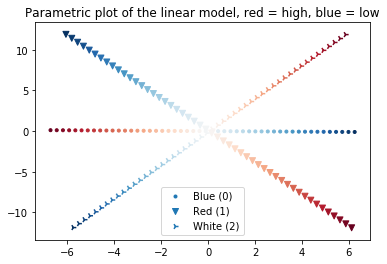

In [9]:
# Parametric plot of the linear model
t = np.linspace(-1, 1)
markers = ('.', 'v', '4')
for i in range(0,3):
    plt.scatter(weights0[0, i] * t + biases0[i], weights0[1, i]*t, marker=markers[i], c=t, cmap="RdBu_r")
plt.legend(['Blue (0)', 'Red (1)', 'White (2)']);
plt.title('Parametric plot of the linear model, red = high, blue = low');

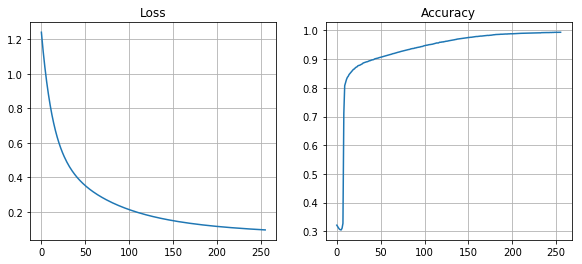

In [10]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(hist0.history['loss'])
plt.grid()
plt.title('Loss')
plt.subplot(1,3,2)
plt.plot(hist0.history['acc'])
plt.grid()
plt.title('Accuracy');

#### Testing the model

In [11]:
yEst0 = model0.predict(xTest)
labelEst0 = np.argmax(yEst0, axis=1)

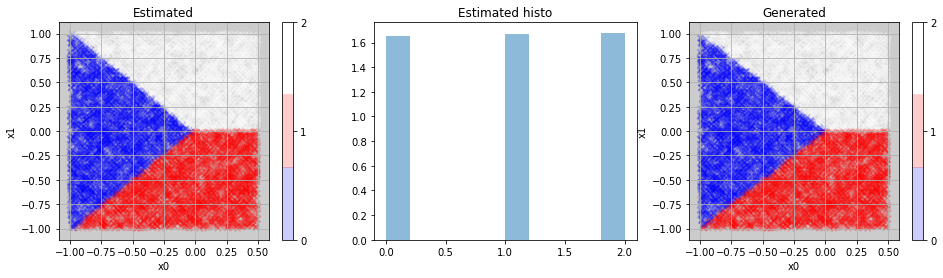

In [12]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
flagPlot(xTest[:,0], xTest[:,1], labelEst0, 'Estimated', czechColors)
plt.subplot(1,3,2)
plt.hist(labelEst0, 10, density=True, alpha=0.5)
plt.title('Estimated histo')
plt.subplot(1,3,3)
flagPlot(xTest[:,0], xTest[:,1], yTest, 'Generated', czechColors)

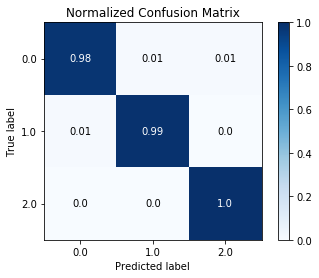

In [13]:
skplt.metrics.plot_confusion_matrix(yTest, labelEst0, normalize=True);

In [14]:
print(skMetrics.classification_report(yTest, labelEst0))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      3315
         1.0       0.99      0.99      0.99      3343
         2.0       0.99      1.00      0.99      3342

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



#### Conclusions on initial model

Fitting is excellent, the separation of the classes is very accurate

Verification is done that the Czech flag is linearly separable.

## Norway flag regression

Norway's flag is more challenging than the Czech one as it contains a double white-blue cross.

Evidently it is not linearly separable. Actualy, this class of problems, the simplest being the XOR truth table, is one motivation to neural networks.

### Data model for the Norway flag

Geometry is modified to get quasi equiprobable categories

In [15]:
# Norway flag colors
norwayColors = ['red', 'white', 'navy']
# Generate a multi class sample based on the Czech banner geometry. Tip of the triangle if at the origin
def generateNorwayBatch(n):
    # xMax adjusted such that the 3 classes are quasi equiprobable
    xMin = np.array([-1, -1])
    xMax = np.array([1, 1])
    #
    x = random.uniform(xMin, xMax, (n, nFeatures))
    a1 = 0.43
    a2 = 0.18
    y = np.zeros(n)                                                                # Red = background
    y[((x[:,0] > -a1) & (x[:,0] < a1)) | ((x[:,1] > -a1) & (x[:,1] < a1))]  = 1    # White cross
    y[((x[:,0] > -a2) & (x[:,0] < a2)) | ((x[:,1] > -a2) & (x[:,1] < a2))]  = 2    # Navy cross over white
    return x, y

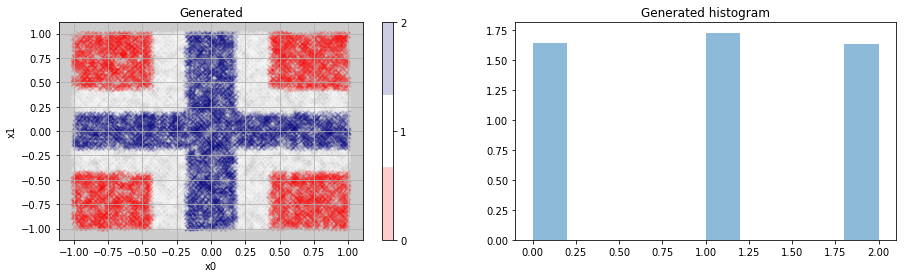

In [16]:
N = 10000
xTrain1, yTrain1 = generateNorwayBatch(N)
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
flagPlot(xTrain1[:,0], xTrain1[:,1], yTrain1, 'Generated', norwayColors)
plt.subplot(1,2,2)
plt.hist(yTrain1, 10, density=True, alpha=0.5)
plt.title('Generated histogram');

### Test data

In [17]:
xTest1, yTest1 = generateNorwayBatch(N)

### Single layer model

In [18]:
nEpoch = 32
nBatch = 128

# Model
model1 = keras.models.Sequential([
  keras.layers.Dense(nClasses, activation=keras.activations.softmax, input_shape=[nFeatures],
                    kernel_regularizer=keras.regularizers.l1(0.001))
])
model1.compile(optimizer='adam',
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# Fit single layer model on Norway data
hist1 = model1.fit(xTrain1, yTrain1, epochs=nEpoch, batch_size=nBatch, verbose=0, callbacks=callbacks)

In [19]:
weights1, biases1 = model1.get_weights()
print('Est W=', weights1)
print('b=', biases1)

Est W= [[5.0458547e-02 4.4087224e-02 6.2018290e-02]
 [3.8588163e-02 5.9499856e-02 4.4319109e-05]]
b= [-0.01503226  0.03857659 -0.01800883]


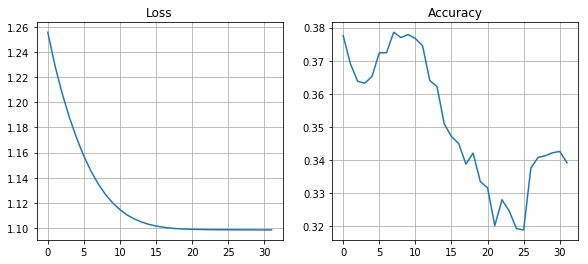

In [20]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(hist1.history['loss'])
plt.grid()
plt.title('Loss')
plt.subplot(1,3,2)
plt.plot(hist1.history['acc'])
plt.grid()
plt.title('Accuracy');

#### Testing the model

In [21]:
yEst1 = model1.predict(xTest1)
labelEst1 = np.argmax(yEst1, axis=1)

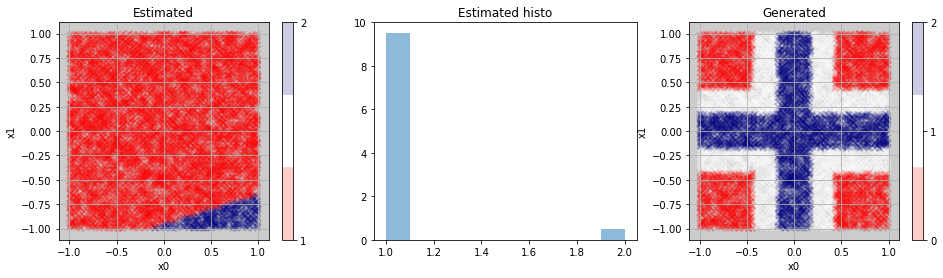

In [22]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
flagPlot(xTest1[:,0], xTest1[:,1], labelEst1, 'Estimated', norwayColors)
plt.subplot(1,3,2)
plt.hist(labelEst1, 10, density=True, alpha=0.5)
plt.title('Estimated histo')
plt.subplot(1,3,3)
flagPlot(xTest1[:,0], xTest1[:,1], yTest1, 'Generated', norwayColors)

As expected, the linear model is not able to separate the classes.

### Two layer model on Norway

In [23]:
nEpoch = 256
nBatch = 128

# Model
model2 = keras.models.Sequential([
    keras.layers.Dense(16, activation=keras.activations.linear, input_shape=[nFeatures],
                        kernel_regularizer=keras.regularizers.l1(0.001),
                        bias_regularizer=keras.regularizers.l1(0.001)),
    keras.layers.Activation(keras.activations.relu),
    keras.layers.Dense(nClasses, activation=keras.activations.softmax)
])
model2.compile(optimizer='adam',
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# Fit two layer model on Norway data
hist2 = model2.fit(xTrain1, yTrain1, epochs=nEpoch, batch_size=nBatch, verbose=0, callbacks=callbacks)

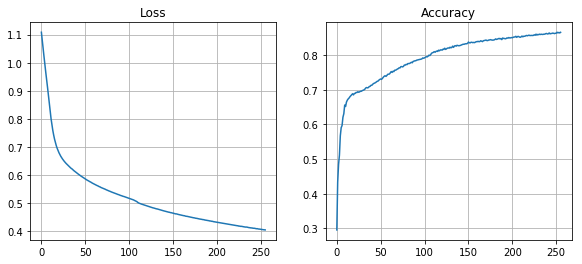

In [24]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(hist2.history['loss'])
plt.grid()
plt.title('Loss')
plt.subplot(1,3,2)
plt.plot(hist2.history['acc'])
plt.grid()
plt.title('Accuracy');

#### Testing the model

In [25]:
yEst2 = model2.predict(xTest1)
labelEst2 = np.argmax(yEst2, axis=1)

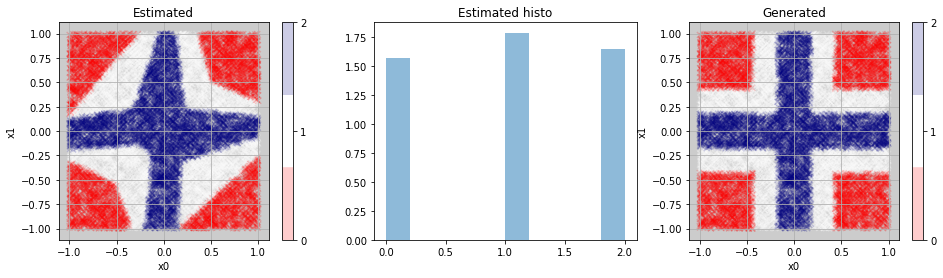

In [26]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
flagPlot(xTest1[:,0], xTest1[:,1], labelEst2, 'Estimated', norwayColors)
plt.subplot(1,3,2)
plt.hist(labelEst2, 10, density=True, alpha=0.5)
plt.title('Estimated histo')
plt.subplot(1,3,3)
flagPlot(xTest1[:,0], xTest1[:,1], yTest1, 'Generated', norwayColors)

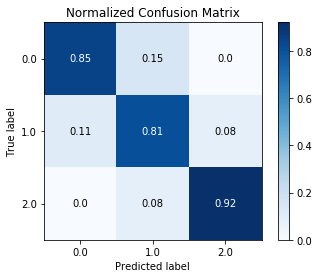

In [27]:
skplt.metrics.plot_confusion_matrix(yTest1, labelEst2, normalize=True);

The two layer neural network is improving compared to the single layer (linear) model. 

Accuracy is greatly improved ranging from ~60% to 95% depending on the fitting convergence

In [38]:
print(skMetrics.classification_report(yTest1, labelEst2))

              precision    recall  f1-score   support

         0.0       0.88      0.85      0.86      3232
         1.0       0.79      0.81      0.80      3476
         2.0       0.92      0.92      0.92      3292

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



### Three layer  neural network on Norway

In [28]:
nEpoch = 256
nBatch = 128

# Model
model3 = keras.models.Sequential([
    keras.layers.Dense(8, activation=keras.activations.linear, input_shape=[nFeatures],
                        kernel_regularizer=keras.regularizers.l1(0.001),
                        bias_regularizer=keras.regularizers.l1(0.001)),
    keras.layers.Activation(keras.activations.relu),
    keras.layers.Dense(8, activation=keras.activations.linear,
                       kernel_regularizer=keras.regularizers.l1(0.001),
                       bias_regularizer=keras.regularizers.l1(0.001)),
    keras.layers.Activation(keras.activations.relu),
    keras.layers.Dense(nClasses, activation=keras.activations.softmax)
])
model3.compile(optimizer='adam',
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# Fit on Norway data
hist3 = model3.fit(xTrain1, yTrain1, epochs=nEpoch, batch_size=nBatch, verbose=0, callbacks=callbacks)

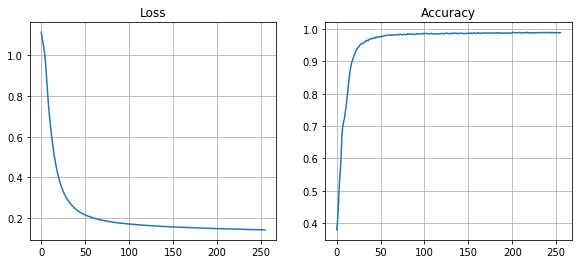

In [29]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(hist3.history['loss'])
plt.grid()
plt.title('Loss')
plt.subplot(1,3,2)
plt.plot(hist3.history['acc'])
plt.grid()
plt.title('Accuracy');

#### Testing the model

In [30]:
yEst3 = model3.predict(xTest1)
labelEst3 = np.argmax(yEst3, axis=1)

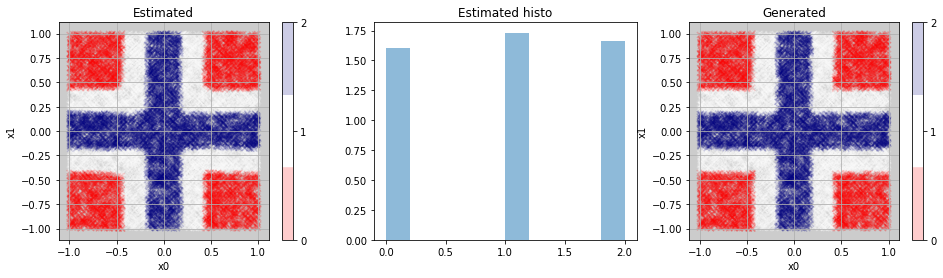

In [31]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
flagPlot(xTest1[:,0], xTest1[:,1], labelEst3, 'Estimated', norwayColors)
plt.subplot(1,3,2)
plt.hist(labelEst3, 10, density=True, alpha=0.5)
plt.title('Estimated histo')
plt.subplot(1,3,3)
flagPlot(xTest1[:,0], xTest1[:,1], yTest1, 'Generated', norwayColors)

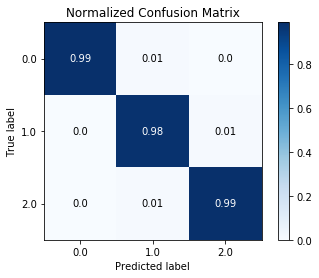

In [32]:
skplt.metrics.plot_confusion_matrix(yTest1, labelEst3, normalize=True);

In [33]:
print(skMetrics.classification_report(yTest1, labelEst3))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      3232
         1.0       0.99      0.98      0.98      3476
         2.0       0.99      0.99      0.99      3292

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



The three layer neural network is almost perfectly macthing the function to fit!

A large added value of the (deep) neural net is shown... at the expense of a much more complex model:

In [39]:
weights3 = model3.get_weights()
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 8)                 24        
_________________________________________________________________
activation_1 (Activation)    (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 72        
_________________________________________________________________
activation_2 (Activation)    (None, 8)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 27        
Total params: 123
Trainable params: 123
Non-trainable params: 0
_________________________________________________________________


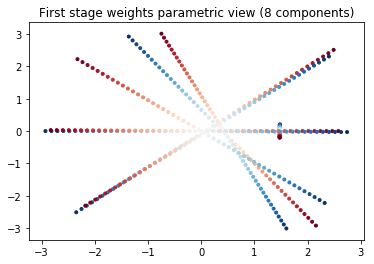

In [35]:
t = np.linspace(-1, 1)
width3_1 = len(weights3[1])
for i in range(0,width3_1):
    plt.scatter(weights3[0][0, i] * t + weights3[1][i], weights3[0][1, i] * t, marker='.', c=t, cmap="RdBu_r")
plt.title('First stage weights parametric view ({:d} components)'.format(width3_1));

In [36]:
weights3[0]

array([[ 2.4193752e+00, -2.1193156e-03,  1.7591865e+00, -2.2897499e+00,
         2.7533498e+00, -1.1741000e+00, -2.7858789e+00, -2.3237627e+00],
       [ 2.5126646e+00, -2.0493197e-01, -2.9244061e+00, -2.3087091e+00,
         2.6248954e-04,  3.0132794e+00,  3.0220244e-02,  2.2243011e+00]],
      dtype=float32)